# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## 1. the camera calibration using chessboard images

In [2]:
import numpy as np
import math
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.max_open_warning']=0


# test image files
camera_fnames = glob.glob('camera_cal/calibration*.jpg')
straight_fnames = glob.glob('test_images/straight*.jpg')
test_fnames = glob.glob('test_images/test*.jpg')
project_fnames = glob.glob('test_images/project/project*.png')
challenge_fnames = glob.glob('test_images/challenge/challenge*.png')

# global variables
mtx = None
dist = None
M = None
Minv = None

def plot_images(imgs, titles=None):
    """
    plot images of list in two columns
    """
    j_plots = 2
    i_plots = math.ceil(len(imgs)/j_plots)

    fig, axes = plt.subplots(i_plots, j_plots, figsize=(15, 5*i_plots))
    plt.tight_layout(pad=1, w_pad=1, h_pad=2.0)
    axes = axes.reshape(-1, 2)     
    
    i = 0
    for img in imgs:
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i//j_plots, i%j_plots].imshow(img)
            pass
        else:
            axes[i//j_plots, i%j_plots].imshow(img, cmap='gray')
            
        if titles is not None:
            axes[i//j_plots, i%j_plots].set_title(titles[i])
        i += 1
    
    return


def calibrate_camera(img_fnames, plot=False):
    """
    get camera mtx and dist from chess board images.
    """
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    nx = 9
    ny = 6
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    imgs = []
    titles = []

    # Step through the list and search for chessboard corners
    for fname in img_fnames[:3]:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img_chess = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)

            imgs.append(img_chess)
            titles.append(fname.split('/')[-1])
            #plt.show()
            #cv2.waitKey(500)

    #cv2.destroyAllWindows()
    if plot:
        plot_images(imgs, titles)
        
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
        objpoints, imgpoints, gray.shape[ : :-1], None, None)
    
    return mtx, dist

def undist_image(img):
    uimg = cv2.undistort(img, mtx, dist, None, mtx)
    return uimg



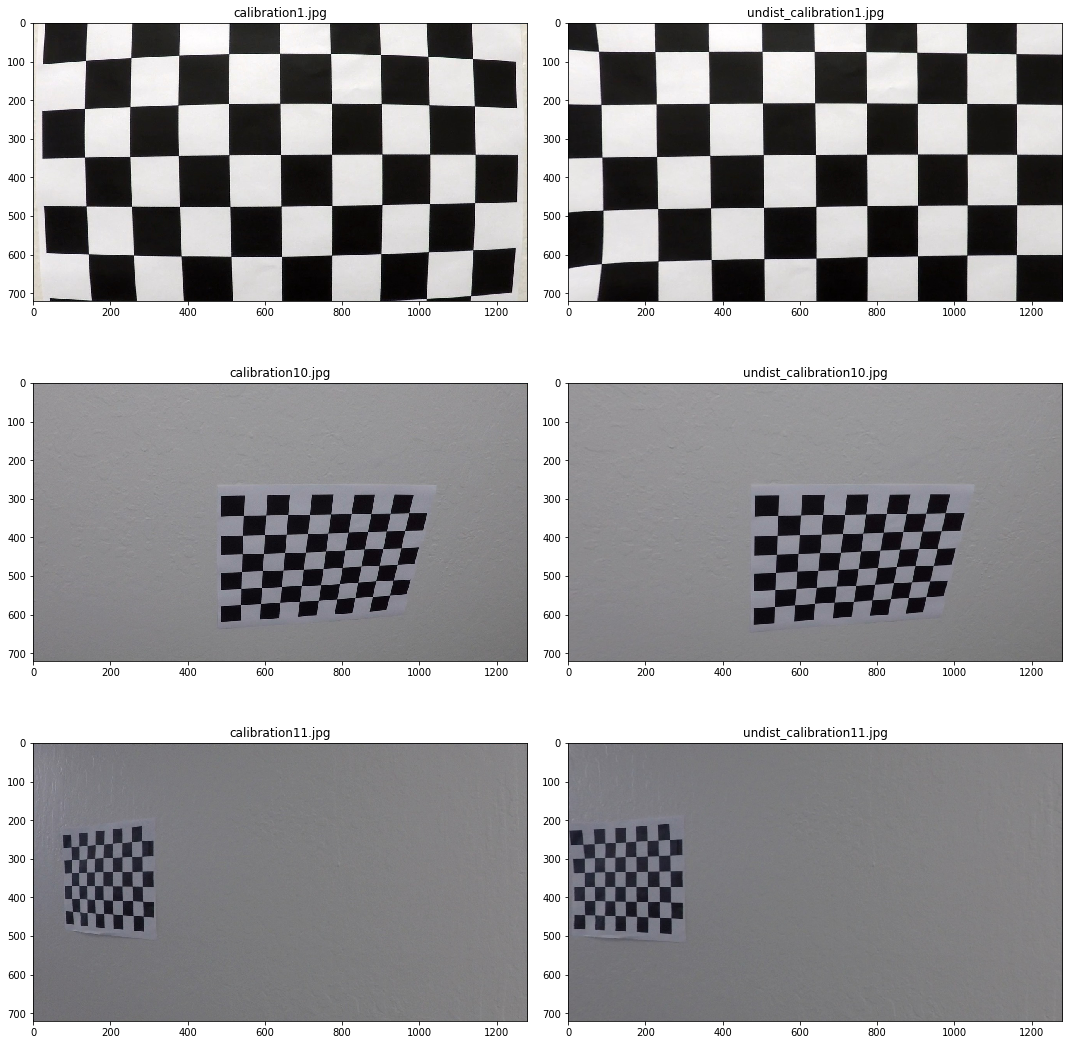

In [3]:
mtx, dist = calibrate_camera(camera_fnames)

cal_imgs = []
cal_titles = []
for camera_fname in camera_fnames[:3]:
    cal_img = cv2.imread(camera_fname)
    cal_imgs.append(cal_img)
    cal_titles.append(camera_fname.split('/')[-1])
    
    ucal_img = undist_image(cal_img)
    cal_imgs.append(ucal_img)
    cal_titles.append('undist_'+camera_fname.split('/')[-1])

plot_images(cal_imgs, cal_titles)



## 2. Thresholding by gradient and color

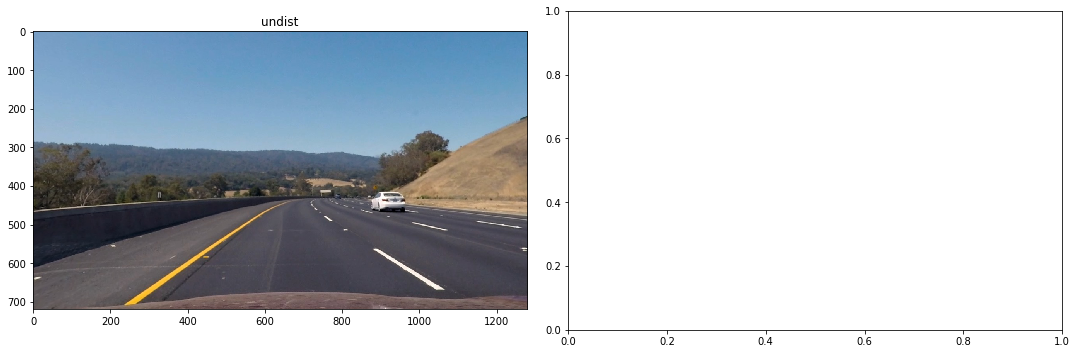

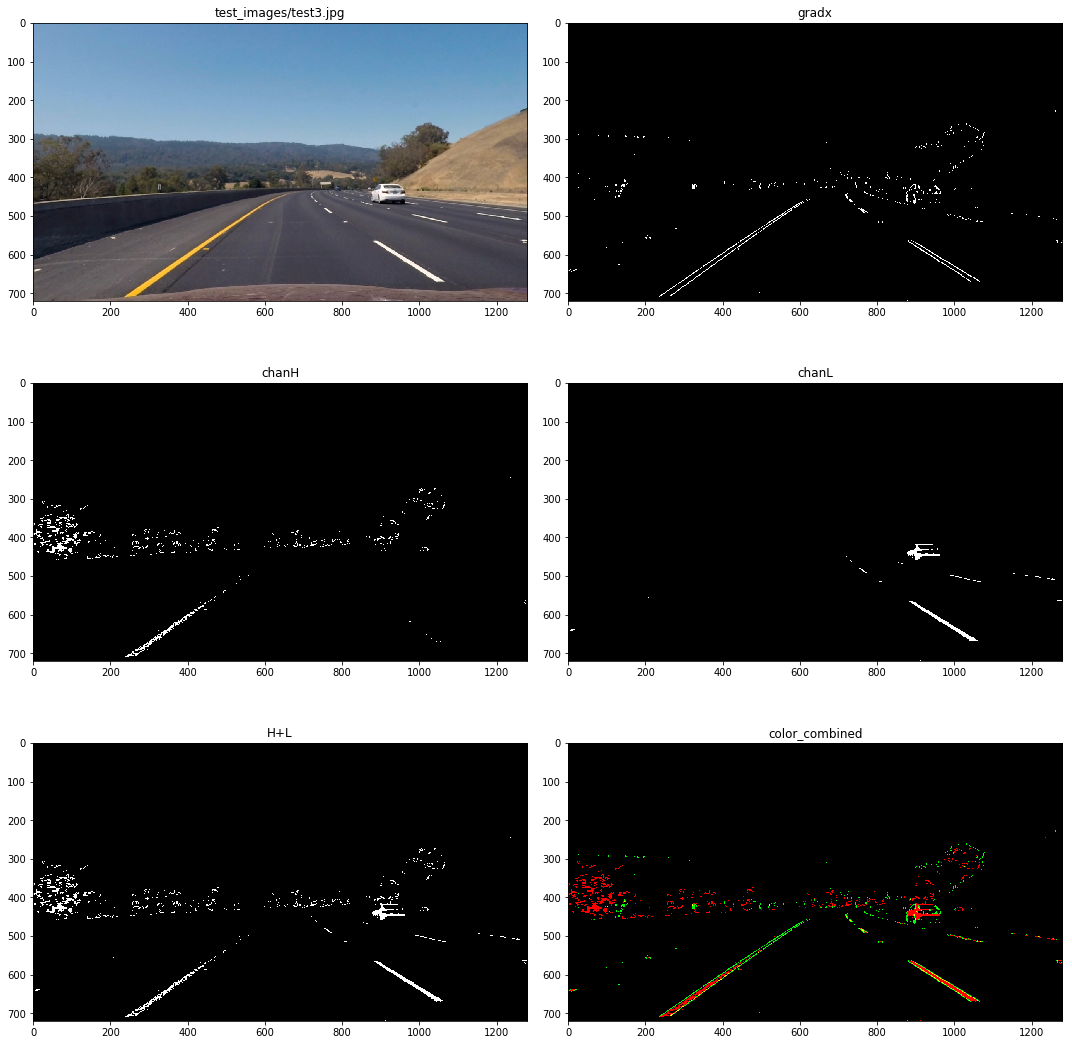

In [246]:
def bin_threshold_for_lane(img, sobel_kernel=3, x_thresh=(50, 255), y_thresh=(20, 100), 
                          mag_thresh=(20, 100), dir_thresh=(0.7, 1.3),
                         h_thresh=(20,21), l_thresh=(205,255), s_thresh=(95, 140),
                          plot=False, fname=None):
    #sobel_kernel=3, x_thresh=(50, 255), y_thresh=(20, 100), 
    #mag_thresh=(20, 100), dir_thresh=(0.7, 1.3),
    #h_thresh=(20,21), l_thresh=(205,255), s_thresh=(170, 255)
    #m 30, 100, s 170, 255
    
    out_images = []
    out_titles = []
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
 
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel) 
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel) 

    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    mag_sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
    
  

    def scaled_255(binary):
        return np.uint8(binary/np.max(binary)*255)
    
    scaled_sobelx = scaled_255(abs_sobelx)
    scaled_sobely = scaled_255(abs_sobely)
    scaled_sobelm = scaled_255(mag_sobel)
    
    gradx = np.zeros_like(gray)
    gradx[((scaled_sobelx > x_thresh[0]) & (scaled_sobelx < x_thresh[1]))] = 1
    grady = np.zeros_like(gray)
    grady[((scaled_sobely > y_thresh[0]) & (scaled_sobely < y_thresh[1]))] = 1
    gradm = np.zeros_like(gray)
    gradm[((scaled_sobelx > mag_thresh[0]) & (scaled_sobelm < mag_thresh[1]))] = 1
    
    sobel_dir = np.arctan2(abs_sobely, abs_sobelx)  
    gradd = np.zeros_like(gray)
    gradd[(sobel_dir > dir_thresh[0]) & (sobel_dir <= dir_thresh[1])] = 1
    
    grad = np.zeros_like(gray)
    grad[((gradx == 1) & (grady == 1)) | ((gradm == 1) & (gradd == 1))] = 1  
    
        
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    chanh = np.zeros_like(gray)
    chanl = np.zeros_like(gray)
    chans = np.zeros_like(gray)
    chanh[(h_channel > h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    chanl[(l_channel > l_thresh[0]) & (l_channel <= l_thresh[1])] = 1  
    chans[(s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
  
    chan = np.zeros_like(gray)
    chan[((chanh == 1) | (chanl == 1))] = 1
    
    color_combined = np.dstack((np.zeros_like(gray), 
                                scaled_255(gradx),
                                scaled_255(chan)))

    combined = np.zeros_like(gray)
    combined[(gradx == 1) | (chan == 1)] = 1

    if plot:
        out_images.extend([img, gradx, chanh, chanl, chan, color_combined])
        if fname is None:
            fname = 'org'
        else:
            out_titles.extend([fname, 'gradx', 'chanH', 'chanL', 'H+L', 'color_combined'])
        plot_images(out_images, out_titles)
    
    return combined


"""
for fname in test_fnames:
    test_img = cv2.imread(fname)
    uimg = undist_image(test_img)
    bin_threshold_for_lane(uimg, plot=True)
    

for fname in project_fnames:
    test_img = cv2.imread(fname)
    uimg = undist_image(test_img)
    bin_threshold_for_lane(uimg, plot=True)
"""                              


#for fname in ['test_images/project/project_0541.png']:
for fname in ['test_images/test3.jpg']:
#for fname in test_fnames:
    test_img = cv2.imread(fname)
    uimg = undist_image(test_img)
    plot_images([uimg], ['undist'])
    bin_threshold_for_lane(uimg, plot=True, fname=fname)

## 3. Bird eye view

[[ 192  720]
 [ 588  453]
 [ 691  453]
 [1100  720]] [[345 720]
 [345   0]
 [934   0]
 [934 720]]


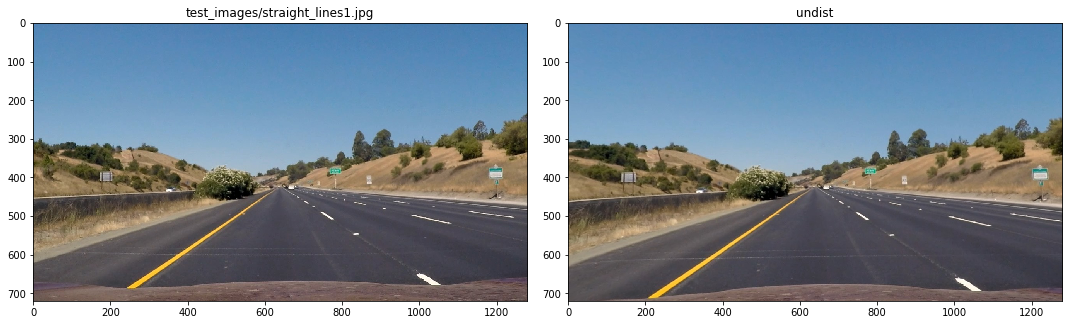

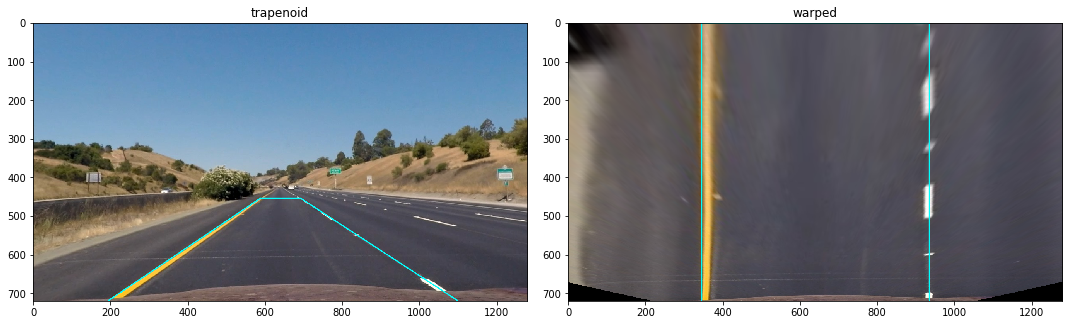

In [249]:
def warp_perspective(img, M):
    h, w = img.shape[:2]
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped

def bird_eye_view_for_lane(img, M, src_pts, dst_pts):
    #pts = src_pts.reshape((-1,1,2))
    #dst_pts = dst_pts.reshape((-1,1,2))
    
    trp = np.copy(img)
    if len(img.shape) == 2:
        color_l = 255
    else:
        color_l = (255, 255, 0)
        
    poly_pts = np.int32(src_pts)
    cv2.polylines(trp, [poly_pts], True, color_l, thickness=2, lineType=cv2.LINE_AA)

    warped = warp_perspective(img, M)

    poly_pts = np.int32(dst_pts)
    cv2.polylines(warped, [poly_pts], True, color_l, thickness=2, lineType=cv2.LINE_AA)    
    
    plot_images([trp, warped], ['trapenoid', 'warped'])
    return

img = cv2.imread(straight_fnames[0])
img_w = img.shape[1]
img_h = img.shape[0]

src_pts = np.array([
[img_w*(0.15),img_h],
[img_w*(0.5-0.040), img_h*(0.5+0.13)], 
[img_w*(0.5+0.040), img_h*(0.5+0.13)], 
[img_w*(1-0.15+0.01),img_h]], dtype=np.float32)

dst_pts = np.array([
[img_w*(0.5-0.23),img_h],
[img_w*(0.5-0.23), 0], 
[img_w*(0.5+0.23), 0], 
[img_w*(0.5+0.23),img_h]], dtype=np.float32)

print(np.int32(src_pts), np.int32(dst_pts))
M = cv2.getPerspectiveTransform(src_pts, dst_pts)
Minv = cv2.getPerspectiveTransform(dst_pts, src_pts)
    

undist = undist_image(img)
plot_images([img, undist], [straight_fnames[0], 'undist'])
bird_eye_view_for_lane(undist, M, src_pts, dst_pts)


## 4. Sliding window for lanes

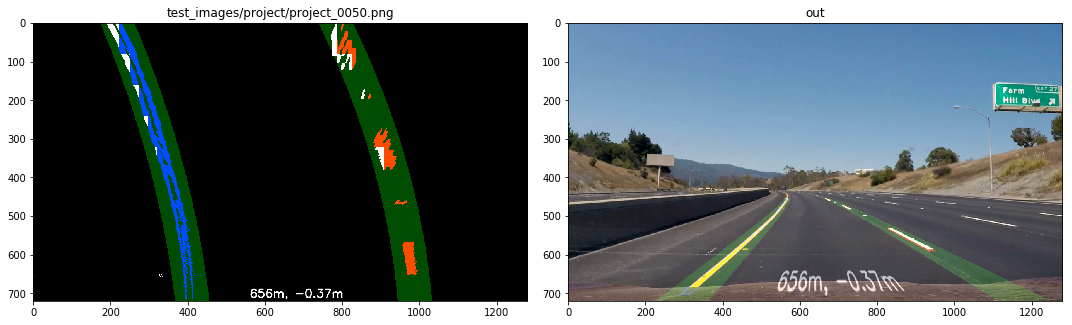

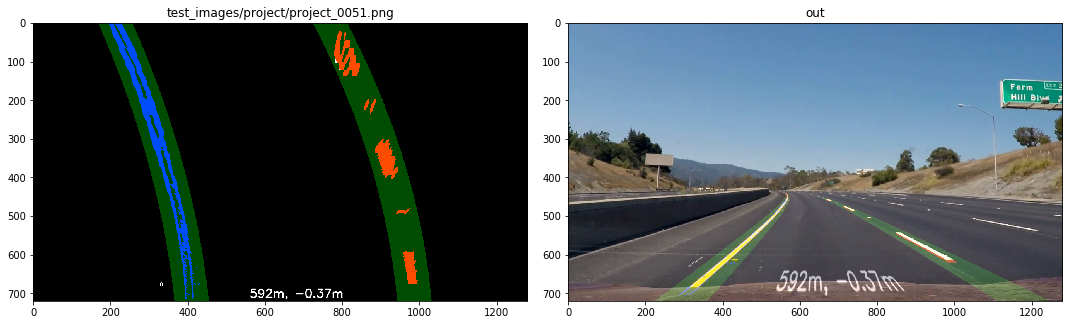

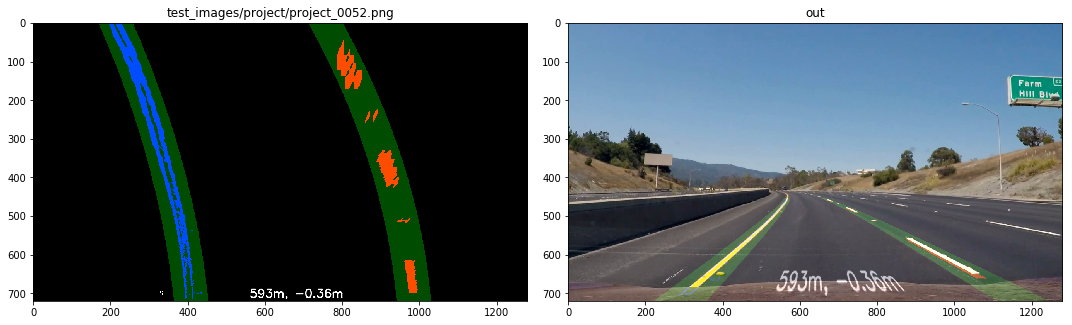

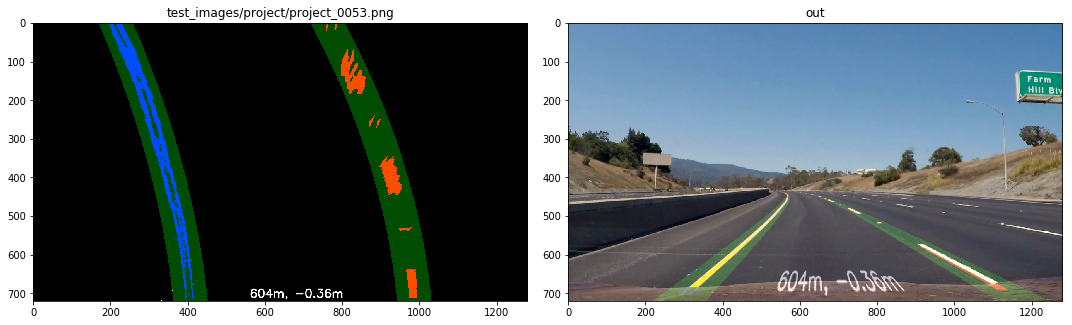

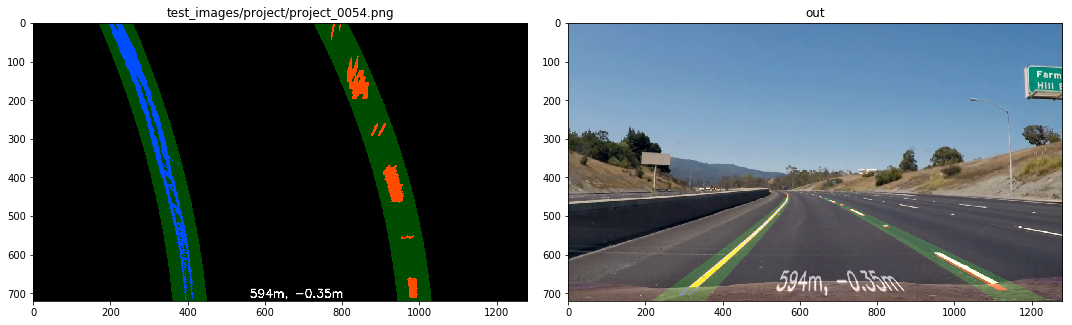

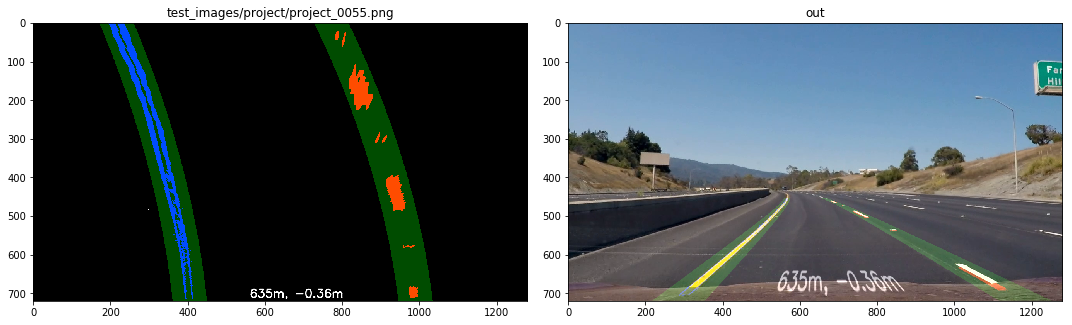

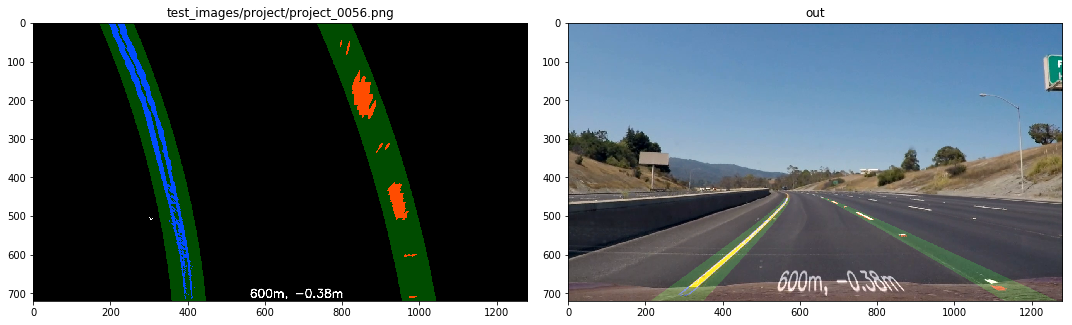

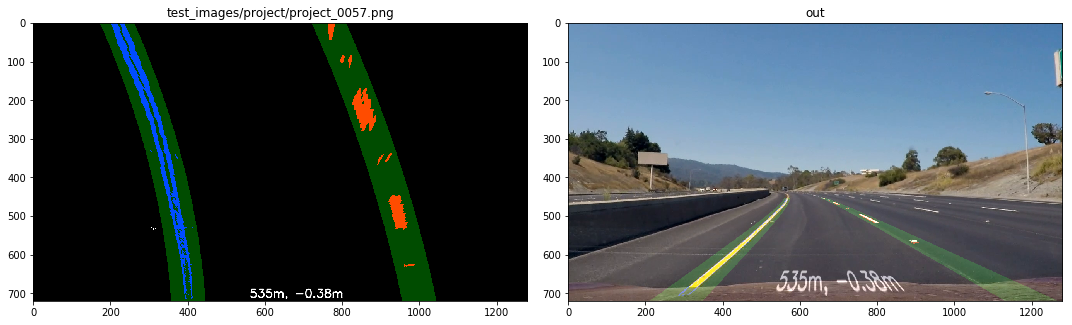

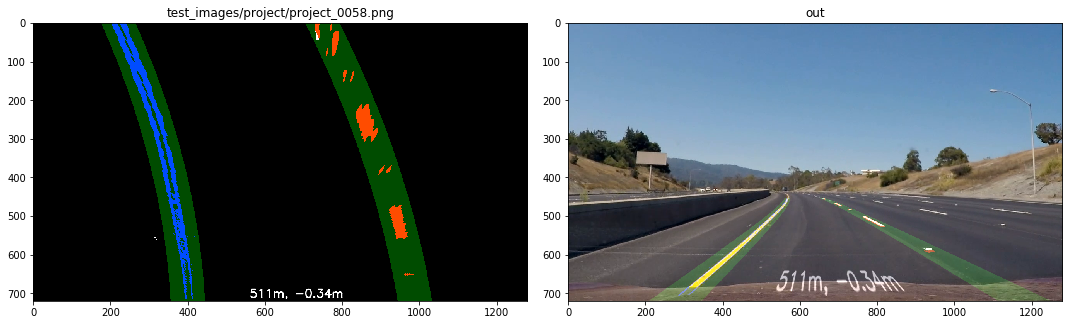

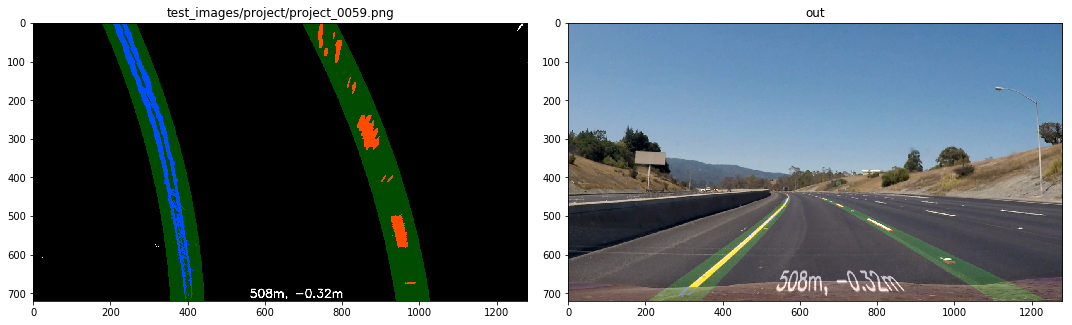

In [293]:
p_left_fit = [0, 0, 0]
p_right_fit = [0, 0, 0]

p_leftx = 0
p_lefty = 0
p_rightx = 0
p_righty = 0

p_curverad = 0
p_offset = 0

lane_maxwidth = 4.5
curve_margin = 500
margin = 44 # Set the width of the windows +/- margin
minpix = 10 # Set minimum number of pixels found to recenter window

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/589 # 3.7/600 # meters per pixel in x dimension
    
def cal_curvature(img, leftx, lefty, rightx, righty):

    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = (
        (1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5 / 
                        np.absolute(2*left_fit_cr[0]))
    right_curverad = (
        (1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5 / 
                        np.absolute(2*right_fit_cr[0]))
    
    #leftx_bottom_cr = left_fit_cr[0]*(y_eval*ym_per_pix) + left_fit_cr[1]*(y_eval*ym_per_pix) + left_fit_cr[2]
    #rightx_bottom_cr = right_fit_cr[0]*(y_eval*ym_per_pix) + right_fit_cr[1]*(y_eval*ym_per_pix) + right_fit_cr[2]
    

    return left_curverad, right_curverad
    
    
def search_by_window(img, rect_img3, nonzerox, nonzeroy, plot=False):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one 
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin 
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        if plot:
            cv2.rectangle(rect_img3,
                          (win_xleft_low,win_y_low),
                          (win_xleft_high,win_y_high),(0,255,0), 2)
            cv2.rectangle(rect_img3,
                          (win_xright_low,win_y_low),
                          (win_xright_high,win_y_high),(0,255,0), 2)

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)
                         ).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)
                          ).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    return left_lane_inds, right_lane_inds


def sanity_check(img, nonzerox, nonzeroy, left_lane_inds, right_lane_inds, fname=fname):
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    if (lefty.size == 0) | (righty.size == 0) | (rightx.size == 0) | (righty.size == 0):
        #print('window fails=', fname)
        return False

    # Fit a second order polynomial
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    #print(left_fit, right_fit)
    abs_left_fit = np.absolute(left_fit)
    abs_right_fit = np.absolute(right_fit)
    
    global p_left_fit
    global p_right_fit
    global p_leftx
    global p_lefty
    global p_rightx
    global p_righty
    global p_curverad
    global p_offset
    
     
    # calculate our radius of curvature in meters
    # Example values: 632.1 m    626.2 m
    left_curverad, right_curverad = cal_curvature(img, leftx, lefty, rightx, righty)

    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    x_width = right_fitx[-1] - left_fitx[-1]
    offset = (img.shape[1]/2.0 - x_width/2.0 - left_fitx[-1])*xm_per_pix
    
    # check the difference to the left and the right curverad and lane width
    if ((p_curverad == 0) | 
            (abs(left_curverad - right_curverad) < curve_margin) &
            (lane_maxwidth > x_width*xm_per_pix)):
        #print((fname.split('/')[-1], ': update ', 
        #abs(left_curverad-right_curverad), left_curverad, right_curverad, x_width*xm_per_pix, offset))
        
        p_curverad = left_curverad
        p_offset = offset
        
        p_left_fit = left_fit
        p_right_fit = right_fit

        p_leftx = leftx
        p_lefty = lefty
        p_rightx = rightx
        p_righty = righty
        
        return True
    else: 
        #print((fname.split('/')[-1], ': retain ', 
        #abs(left_curverad-right_curverad), left_curverad, right_curverad, x_width*xm_per_pix, offset))
        return False
        
        
def search_window_for_lane(img, plot=False, fname=fname):

    nonzero = img.nonzero()
    nonzerox = nonzero[1]
    nonzeroy = nonzero[0]
    
    left_lane_inds = []
    right_lane_inds = []
    #print('*')
    rect_img3 = np.dstack((img, img, img))*255   
    if (p_left_fit[0] != 0) & (p_right_fit[0] != 0):
        left_lane_inds = (
            (nonzerox > 
             (p_left_fit[0]*(nonzeroy**2) + p_left_fit[1]*nonzeroy + p_left_fit[2] - margin)) & 
            (nonzerox < 
             (p_left_fit[0]*(nonzeroy**2) + p_left_fit[1]*nonzeroy + p_left_fit[2] + margin))) 
        
        right_lane_inds = (
            (nonzerox > 
             (p_right_fit[0]*(nonzeroy**2) + p_right_fit[1]*nonzeroy + p_right_fit[2] - margin)) & 
            (nonzerox < 
             (p_right_fit[0]*(nonzeroy**2) + p_right_fit[1]*nonzeroy + p_right_fit[2] + margin)))  
        
        #print('using previous fit > sanity')
        if not sanity_check(rect_img3, nonzerox, nonzeroy, left_lane_inds, right_lane_inds, fname=fname):
            #print('using previous fit > window > sanity')
            # Retry a search by sliding window.
            left_lane_inds, right_lane_inds = search_by_window(img, rect_img3, nonzerox, nonzeroy, plot=plot)
            sanity_check(rect_img3, nonzerox, nonzeroy, left_lane_inds, right_lane_inds, fname=fname)
    
    else:
        #print('using sliding window again')
        left_lane_inds, right_lane_inds = search_by_window(img, rect_img3, nonzerox, nonzeroy, plot=plot)
        sanity_check(rect_img3, nonzerox, nonzeroy, left_lane_inds, right_lane_inds, fname=fname)
    


    
    # Draw fit dot lanes 
    rect_img3[p_lefty, p_leftx] = [255, 0, 0]
    rect_img3[p_righty, p_rightx] = [0, 0, 255]
    
    
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    left_fitx = p_left_fit[0]*ploty**2 + p_left_fit[1]*ploty + p_left_fit[2]
    right_fitx = p_right_fit[0]*ploty**2 + p_right_fit[1]*ploty + p_right_fit[2]
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array(
        [np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array(
        [np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    
    right_line_window1 = np.array(
        [np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array(
        [np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Draw fit margin lanes
    poly_img3 = np.zeros_like(rect_img3)
    cv2.fillPoly(poly_img3, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(poly_img3, np.int_([right_line_pts]), (0,255, 0))

    
    result = cv2.addWeighted(rect_img3, 1, poly_img3, 0.3, 0)


    cv2.putText(result,'%dm, %+.2fm'%(p_curverad, p_offset),
            (result.shape[1]//2-80, result.shape[0]-10), 
                cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
    
    if plot:
        plt.figure(figsize=(20,10))
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
    return result


#video_fnames = glob.glob('test_images/project/project_09*.png') #0539. 0603
for fname in project_fnames[50:60]:   
#for fname in challenge_fnames[470:]:
    image = cv2.imread(fname)


    undist_img = undist_image(image)
    binary_thresh = bin_threshold_for_lane(undist_img)
    binary_warped = warp_perspective(binary_thresh, M)
    
    search = search_window_for_lane(binary_warped, fname=fname)
    #search = search_window_for_lane2(binary_warped)
    out = warp_perspective(search, Minv)
    out = cv2.addWeighted(image, 1, out, 0.5, 0)
    plot_images([search, out],[fname, 'out'])




In [26]:
def save_frame(vidcap):

    fcount = 0
    success = True
    while success:
        success,image = vidcap.read()
        fname = 'test_images/challenge/challenge_%04d.png' % (fcount)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        cv2.imwrite(fname, image)
        fcount += 1
    return

vidcap = cv2.VideoCapture('challenge_video.mp4')
%time save_frame(vidcap)


## 5. Searching for lanes on the continuous video frames

In [294]:

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    undist_img = undist_image(bgr)
    binary_thresh = bin_threshold_for_lane(undist_img)
    binary_warped = warp_perspective(binary_thresh, M)
    
    lane = search_window_for_lane(binary_warped, fname=fname)
    unwarped = warp_perspective(lane, Minv)
    out = cv2.addWeighted(image, 1, unwarped, 0.6, 0)

    return out


In [295]:
p_left_fit = [0, 0, 0]
p_right_fit = [0, 0, 0]

p_leftx = 0
p_lefty = 0
p_rightx = 0
p_righty = 0

p_curverad = 0
p_offset = 0

project_output = 'project_output.mp4'
clip = VideoFileClip("project_video.mp4")
output_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!

%time output_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 1260/1261 [03:50<00:00,  5.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 4min 4s, sys: 1min 1s, total: 5min 5s
Wall time: 3min 51s


In [296]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(project_output))